In [558]:
import netCDF4
import matplotlib.pyplot as plt
import json
from datetime import datetime, timezone
import os
import numpy as np
import pandas as pd
from pyproj import Transformer
import dfm_tools as dfmt
import sys
import xarray as xr
import pytz

In [559]:
from datalakes import parse_nc_datalakes_from_folder, get_timeserie_datalakes, get_profile_datalakes
from delft3d_flow import get_closest_index_by_coord, extract_timeseries_from_output_file_by_coordinates
from alplakes import try_download, download_3d_timeserie_from_api, parse_alplakes_3d_timeserie_from_directory, download_3d_profile_from_api, parse_json_3d_profile_to_df

# Comparison of results from Delft3D Flow, Delft 3D Fm, Alplakes and measurements from Datalakes
This notebook displays :
- the timeserie of the temperature at a given location and depth
- the profile of the temperature at a given location and time
- the heatmap of the profile at a given location

It imports the measure from a netcdf file that can be dowloaded on the datalake platform (https://www.datalakes-eawag.ch/data).
If download_and_merge_timeserie_json = True, then it downloads a month of simulation results on Alplakes via the API (https://www.alplakes.eawag.ch/api) and merges it in the existing json file (if it exist). (a month is roughly the max period supported by the API for Lugano lake).
It imports local results from Delft3D flow and Delft3D FM (MapFormat=4) simulations.

In [ ]:
lake_name = "geneva"
sta_name = 'geneva_lexplore'

lake_name = "zurich"
sta_name = 'lower_zurich'

In [561]:
depth_plot = 1
date_plot_profil = datetime(2024,6,17,0,0)

In [562]:
date_plot_profil_str = date_plot_profil.strftime('%Y%m%d%H%M')

In [563]:
with open(os.path.join('config_points.json'), 'r') as file:
    config_points = json.load(file)[sta_name]
    
lat_station_wgs84 = config_points['lat_station_wgs84']
long_station_wgs84 = config_points['long_station_wgs84']

In [564]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:21781") # WGS84 projection to CH1903 projection
lat_station_ch1903, long_station_ch1903 = transformer.transform(lat_station_wgs84, long_station_wgs84)

# Get data

## Import measure

In [565]:
measure_folder_path = ''
measure_file_path = ''
if not config_points['measure_folder_name'] is None:
    measure_folder_path = os.path.join('data/datalakes', config_points['measure_folder_name'])
if not config_points['measure_file_path'] is None:
    measure_file_path = os.path.join('data/datalakes', config_points['measure_file_path'])

In [566]:
xr_measure = None
plot_measure = False
if measure_file_path != '':
    xr_measure= xr.open_mfdataset(measure_file_path)
elif measure_folder_path != '':
    xr_measure = parse_nc_datalakes_from_folder(measure_folder_path)

if xr_measure is not None:
    meas_timeserie = get_timeserie_datalakes(xr_measure, 'temp', depth_plot)
    meas_profile = get_profile_datalakes(xr_measure, 'temp', date_plot_profil)
    plot_measure = True

## Import results Alplakes simulation

### Timeserie

In [567]:
start_download_alplakes = '202406010000'
end_download_alplakes = '202406210000'
download_timeserie_alplakes = False

alplakes_json_timeserie_directory = rf"data\alplakes_3d\{sta_name}\timeseries_{depth_plot}m"

In [568]:
if download_timeserie_alplakes == True:
    alplakes_download_file_path = os.path.join(alplakes_json_timeserie_directory,
                                f'timeserie_{lake_name}_{start_download_alplakes}_{end_download_alplakes}_{depth_plot}_{lat_station_wgs84}_{long_station_wgs84}.json')
    if not os.path.exists(alplakes_download_file_path):
        download_3d_timeserie_from_api(lake_name,start_download_alplakes,end_download_alplakes,depth_plot,lat_station_wgs84,long_station_wgs84,alplakes_download_file_path)

In [569]:
alplakes_timeserie = parse_alplakes_3d_timeserie_from_directory(alplakes_json_timeserie_directory)

### Profile

In [570]:
alplakes_profile_json_path = rf"data\alplakes_3d\{sta_name}\profiles\profile_{sta_name}_{date_plot_profil_str}m.json"
if not os.path.isfile(alplakes_profile_json_path):
    download_3d_profile_from_api(lake_name, date_plot_profil_str, lat_station_wgs84, long_station_wgs84, alplakes_profile_json_path)
alplakes_profile_data = parse_json_3d_profile_to_df(alplakes_profile_json_path)

## Import simstrat alplakes 1d 

In [571]:
alplakes_1d_json_path = os.path.join(r'data\alplakes_1d', config_points['alplakes_1d_name'])
with open(alplakes_1d_json_path) as f:
    simstrat_json_data = json.load(f)
datetime_list = [datetime.fromisoformat(date_string).replace(tzinfo=None) for date_string in simstrat_json_data['time']]

# Create xarray dataset
simstrat_data = xr.Dataset(
    {
        'temperature': (['depth', 'time'], np.stack(simstrat_json_data['T']))
    },
    coords={
        'time': datetime_list,
        'depth': simstrat_json_data['depths']
    }
)

## Import results local FLOW simulation

In [572]:
def get_flow_results(flow_results_path: str):
    nc_flow = netCDF4.Dataset(flow_results_path)
    flow_coor_index = get_closest_index_by_coord(np.array(nc_flow.variables["XZ"][:]), np.array(nc_flow.variables["YZ"][:]), lat_station_ch1903, long_station_ch1903)
    flow_depth_index = (np.abs(np.array(nc_flow.variables["ZK_LYR"][:]) + depth_plot)).argmin()
    
    flow_times = np.array(nc_flow.variables["time"][:])
    flow_timestamps = [datetime.utcfromtimestamp(t + (datetime(2008, 3, 1).replace(tzinfo=timezone.utc) - datetime(1970, 1, 1).replace(tzinfo=timezone.utc)).total_seconds()).replace(tzinfo=timezone.utc) for t in flow_times]
    flow_depths = np.array(nc_flow.variables["ZK_LYR"])
    flow_x_coor_plot = np.array(nc_flow.variables["XZ"][flow_coor_index[0],flow_coor_index[1]])
    flow_y_coor_plot = np.array(nc_flow.variables["YZ"][flow_coor_index[0],flow_coor_index[1]])
    
    flow_data = np.array(nc_flow.variables['R1'][:,0,:,flow_coor_index[0],flow_coor_index[1]])
    flow_data[flow_data == -999] = np.nan
    flow_timeserie = pd.DataFrame({
        'time': flow_timestamps,
        'temperature':flow_data[:,flow_depth_index]
                                 })
    
    return flow_timeserie, flow_depths, flow_data

Text(0.5, 1.0, 'Temperature lower_zurich at depth 1m')

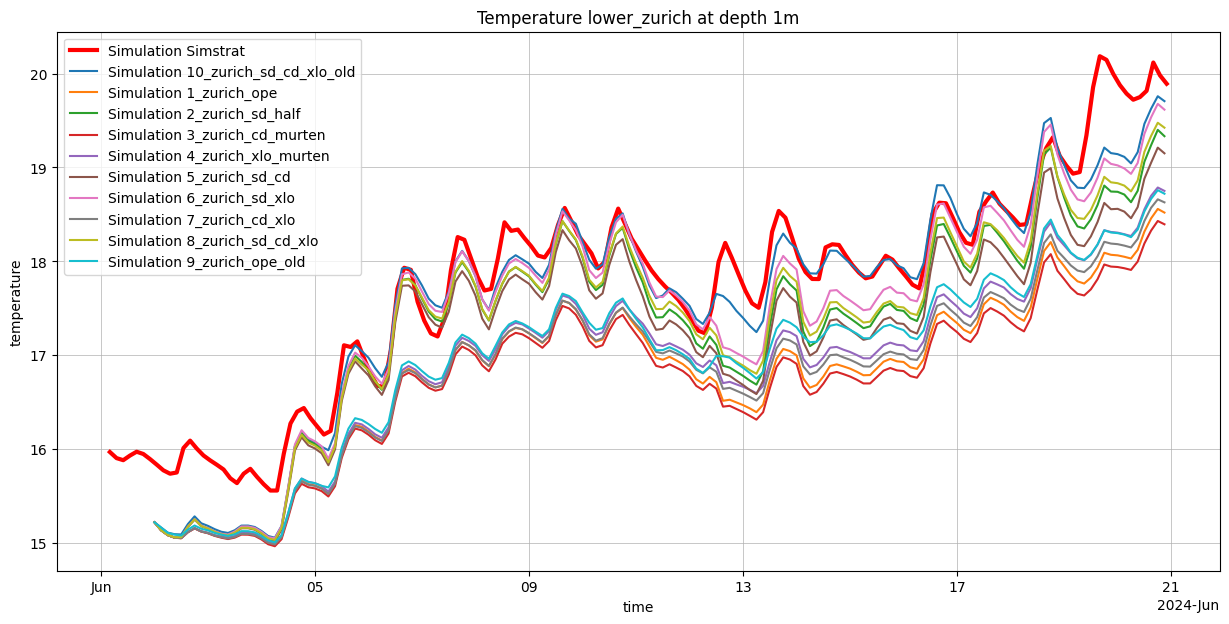

In [573]:
fig = plt.figure(figsize=(15, 7))
start_date = datetime(2024, 6, 1, 0, 0) 
end_date = datetime(2024, 6, 21, 0, 0)

if plot_measure:
    meas_timeserie.sel(time=slice(start_date,end_date)).plot(label=f'Measure', color='r')
else:
    simstrat_data.sel(depth=depth_plot, time=slice(start_date,end_date))['temperature'].plot(label=f'Simulation Simstrat', color='r',linewidth=3)
for item in os.listdir(rf"data\delft3d_flow\{lake_name}"):
    flow_results_path = rf"data\delft3d_flow\{lake_name}\{item}\trim-Simulation_Web.nc"
    flow_timeserie, flow_depths, flow_data = get_flow_results(flow_results_path)
    plt.plot(flow_timeserie['time'],flow_timeserie['temperature'], label=f'Simulation {item}')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.title(f"Temperature {sta_name} at depth {depth_plot}m")

#plt.savefig(rf"output_plots\{lake_name}\comparison_all_simu.png")

# Plot

## Plot timeseries temperature at depth "depth_simu"

In [574]:
flow_sim_name = f'10_{lake_name}_sd_cd_xlo_old'
flow_results_path = rf"data\delft3d_flow\{lake_name}\{flow_sim_name}\trim-Simulation_Web.nc"
flow_timeserie, flow_depths, flow_data = get_flow_results(flow_results_path)

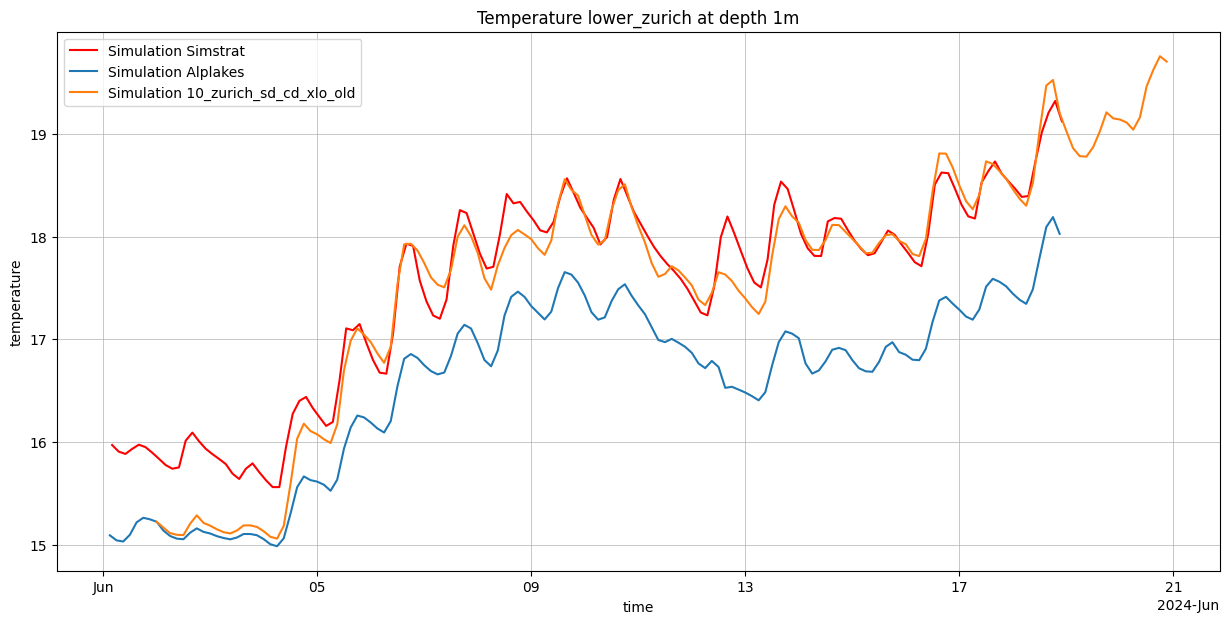

In [579]:
start_date = datetime(2024, 6, 1, 0, 0) 
end_date = datetime(2024, 6, 19, 0, 0)
condition_alplakes = (alplakes_timeserie['time']>start_date) & (alplakes_timeserie['time']<end_date)
#condition_flow = (flow_timeserie['time']>start_date) & (flow_timeserie['time']<end_date)

fig = plt.figure(figsize=(15, 7))
if plot_measure:
    meas_timeserie.sel(time=slice(start_date,end_date)).plot(label=f'Measure', color='r')
else:
    simstrat_data.sel(depth=depth_plot, time=slice(start_date,end_date))['temperature'].plot(label=f'Simulation Simstrat', color='r')
plt.plot(alplakes_timeserie['time'][condition_alplakes],alplakes_timeserie['temperature'][condition_alplakes], label=f'Simulation Alplakes')
plt.plot(flow_timeserie['time'],flow_timeserie['temperature'], label=f'Simulation {flow_sim_name}')
plt.title(f"Temperature {sta_name} at depth {depth_plot}m")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()

#plt.savefig(rf"output_plots\{lake_name}\comp_10.png")

## Plot profils

In [576]:
i_flow_date_plot = (np.abs(np.array(flow_timeserie['time']) - date_plot_profil.replace(tzinfo=timezone.utc))).argmin()

In [577]:
simstrat_temp_profile = simstrat_data.sel(time=date_plot_profil, method='nearest')['temperature'].values
simstrat_depth_profile = -1*simstrat_data.depth.values

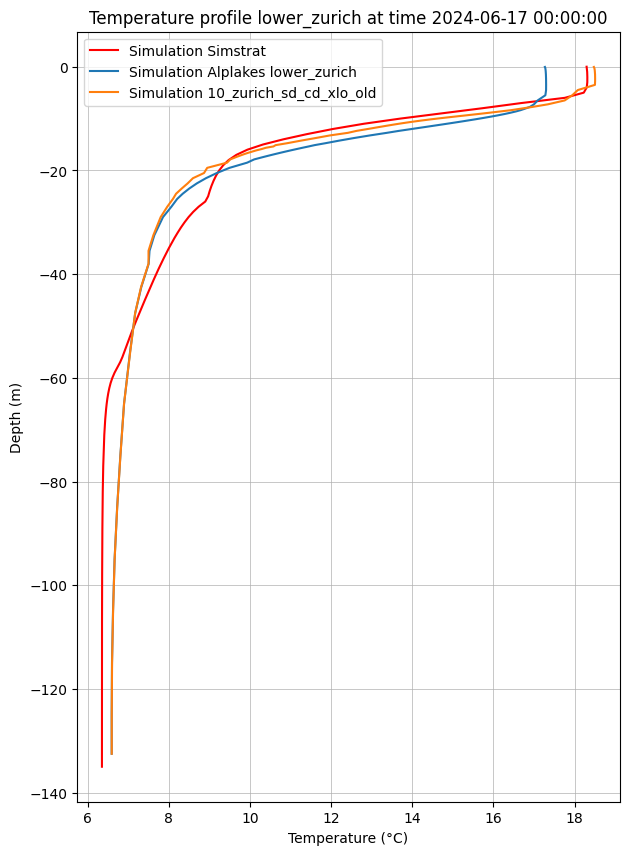

In [580]:
fig = plt.figure(figsize=(7, 10))
if plot_measure:
    plt.plot(meas_profile.values,-1*meas_profile.depth.values, label=f'Measure {sta_name}')
else:
    plt.plot(simstrat_temp_profile, simstrat_depth_profile, label='Simulation Simstrat', color='r')
    
plt.plot(alplakes_profile_data['temperature'],-1*alplakes_profile_data['depth'], label=f'Simulation Alplakes {sta_name}')
plt.plot(flow_data[i_flow_date_plot],flow_depths, label=f'Simulation {flow_sim_name}') 

plt.title(f"Temperature profile {sta_name} at time {date_plot_profil}")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.ylabel('Depth (m)')
plt.xlabel('Temperature (°C)')
plt.legend()
#plt.savefig(rf"output_plots\{lake_name}\profile_{date_plot_profil.date()}.png")